In [1]:
# load Sentinel-2 data
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc
import stackstac
import numpy as np
import rioxarray as rio
import geopandas as gpd
import json
import pandas as pd
import xarray as xr
import dask

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)

### Create a Dask cluster

> from PlanetaryComputerExamples/tutorials/cloudless-mosaic-sentinel2.ipynb

We're going to process a large amount of data. To cut down on the execution time, we'll use a Dask cluster to do the computation in parallel, adaptively scaling to add and remove workers as needed. See [Scale With Dask](../quickstarts/scale-with-dask.ipynb) for more on using Dask.

In [ ]:
from dask_gateway import GatewayCluster
cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.

client = cluster.get_client()

cluster.adapt(minimum=4, maximum=24)
print(cluster.dashboard_link)

In [3]:
area_of_interest_gdf = gpd.read_file('../data/reservoirs/Sirindhorn_800.gpkg')
area_of_interest = area_of_interest_gdf.convex_hull.iloc[0].__geo_interface__
minx, miny, maxx, maxy = area_of_interest_gdf.iloc[0].geometry.bounds

time_of_interest = "2019-01-01/2019-06-30"

In [4]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest
)

# Check how many items were returned
items = search.get_all_items()
print(f"Returned {len(items)} Items")

Returned 36 Items


In [5]:
# load the metadata of all the images in a geopandas dataframe
df = gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
print(df.columns)
df.head()

Index(['geometry', 'datetime', 'platform', 'proj:epsg', 'instruments',
       's2:mgrs_tile', 'constellation', 's2:granule_id', 'eo:cloud_cover',
       's2:datatake_id', 's2:product_uri', 's2:datastrip_id',
       's2:product_type', 'sat:orbit_state', 's2:datatake_type',
       's2:generation_time', 'sat:relative_orbit', 's2:water_percentage',
       's2:mean_solar_zenith', 's2:mean_solar_azimuth',
       's2:processing_baseline', 's2:snow_ice_percentage',
       's2:vegetation_percentage', 's2:thin_cirrus_percentage',
       's2:cloud_shadow_percentage', 's2:nodata_pixel_percentage',
       's2:unclassified_percentage', 's2:dark_features_percentage',
       's2:not_vegetated_percentage', 's2:degraded_msi_data_percentage',
       's2:high_proba_clouds_percentage', 's2:reflectance_conversion_factor',
       's2:medium_proba_clouds_percentage',
       's2:saturated_defective_pixel_percentage'],
      dtype='object')


,geometry,datetime,platform,proj:epsg,instruments,s2:mgrs_tile,constellation,s2:granule_id,eo:cloud_cover,s2:datatake_id,...,s2:cloud_shadow_percentage,s2:nodata_pixel_percentage,s2:unclassified_percentage,s2:dark_features_percentage,s2:not_vegetated_percentage,s2:degraded_msi_data_percentage,s2:high_proba_clouds_percentage,s2:reflectance_conversion_factor,s2:medium_proba_clouds_percentage,s2:saturated_defective_pixel_percentage
0,"POLYGON ((104.99981 15.29517, 105.00565 15.321...",2019-06-30T03:15:41.024000Z,Sentinel-2A,32648,[msi],48PWB,Sentinel 2,S2A_OPER_MSI_L2A_TL_ESRI_20201006T080816_A0209...,88.703004,GS2A_20190630T031541_020993_N02.12,...,0.054462,0.073308,4.047552,0.017581,3.856872,0.0,81.743330,0.967727,6.504431,0.0
1,"POLYGON ((104.99981 15.31024, 105.01132 15.361...",2019-06-25T03:15:49.024000Z,Sentinel-2B,32648,[msi],48PWB,Sentinel 2,S2B_OPER_MSI_L2A_TL_ESRI_20201006T061522_A0120...,74.082522,GS2B_20190625T031549_012013_N02.12,...,0.288605,0.049114,3.462313,0.111272,6.550432,0.0,37.347126,0.968257,15.145716,0.0
2,"POLYGON ((104.99981 15.27853, 105.01685 15.354...",2019-06-20T03:15:41.024000Z,Sentinel-2A,32648,[msi],48PWB,Sentinel 2,S2A_OPER_MSI_L2A_TL_ESRI_20201006T042448_A0208...,18.343147,GS2A_20190620T031541_020850_N02.12,...,2.303102,0.107060,6.612213,0.542806,11.838597,0.0,14.324193,0.969016,3.489082,0.0
3,"POLYGON ((104.99981 15.29520, 105.01447 15.360...",2019-06-15T03:15:49.024000Z,Sentinel-2B,32648,[msi],48PWB,Sentinel 2,S2B_OPER_MSI_L2A_TL_ESRI_20201006T023403_A0118...,73.791877,GS2B_20190615T031549_011870_N02.12,...,0.145672,10.236930,2.910772,0.061697,10.587307,0.0,49.999073,0.970001,12.448049,0.0
4,"POLYGON ((104.99981 15.25200, 105.01366 15.313...",2019-06-10T03:15:41.024000Z,Sentinel-2A,32648,[msi],48PWB,Sentinel 2,S2A_OPER_MSI_L2A_TL_ESRI_20201006T001917_A0207...,52.971618,GS2A_20190610T031541_020707_N02.12,...,0.869482,0.170447,4.888977,0.568944,14.850308,0.0,47.416022,0.971204,4.946829,0.0


<AxesSubplot:xlabel='datetime', ylabel='scene-cloud-cover'>

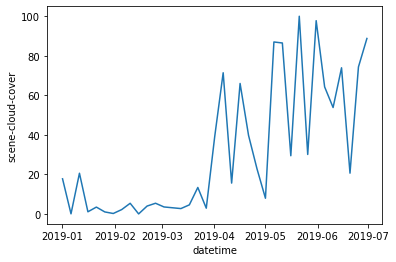

In [6]:
df['scene-cloud-cover'] = df['s2:cloud_shadow_percentage'] + df['s2:thin_cirrus_percentage'] + df['s2:high_proba_clouds_percentage'] + df['s2:medium_proba_clouds_percentage']
df['datetime'] = pd.to_datetime(df['datetime'])

import seaborn as sns

sns.lineplot(x="datetime", y="scene-cloud-cover", data=df)

In [7]:
import rich.table

table = rich.table.Table("Asset Key", "Description")
for asset_key, asset in items[0].assets.items():
    # print(f"{asset_key:<25} - {asset.title}")
    table.add_row(asset_key, asset.title)

table

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key          ┃ Description                           ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ AOT                │ Aerosol optical thickness (AOT)       │
│ B01                │ Band 1 - Coastal aerosol - 60m        │
│ B02                │ Band 2 - Blue - 10m                   │
│ B03                │ Band 3 - Green - 10m                  │
│ B04                │ Band 4 - Red - 10m                    │
│ B05                │ Band 5 - Vegetation red edge 1 - 20m  │
│ B06                │ Band 6 - Vegetation red edge 2 - 20m  │
│ B07                │ Band 7 - Vegetation red edge 3 - 20m  │
│ B08                │ Band 8 - NIR - 10m                    │
│ B09                │ Band 9 - Water vapor - 60m            │
│ B11                │ Band 11 - SWIR (1.6) - 20m            │
│ B12                │ Band 12 - SWIR (2.2) - 20m            │
│ B8A                │ Band 8A - Vegetation red edge 4 - 20m │
│ SCL                │ Scene classfication map (SCL)         │
│ WVP                │ Water vapour (WVP)                    │
│ visual             │ True color image                      │
│ preview            │ Thumbnail                             │
│ safe-manifest      │ SAFE manifest                         │
│ granule-metadata   │ Granule metadata                      │
│ inspire-metadata   │ INSPIRE metadata                      │
│ product-metadata   │ Product metadata                      │
│ datastrip-metadata │ Datastrip metadata                    │
│ tilejson           │ TileJSON with default rendering       │
│ rendered_preview   │ Rendered preview                      │
└────────────────────┴───────────────────────────────────────┘

In [8]:
from IPython.display import Image

Image(url=items[2].assets["rendered_preview"].href, width=800)

Let's load in the data now for analysis. Adapted from PlanetaryComputerExamples/tutorials/cloudless-mosaic-sentinel2.ipynb

In [9]:
signed_items = [pc.sign(item).to_dict() for item in items]

# Process for a single day

For the following processing, extracting the data for a single time

In [10]:
# time_slice_to_get = 10 # less cloudy
time_slice_to_get = 26 # moderately cloudy
# time_slice_to_get = 25 # very cloudy

In [11]:
data = (
    stackstac.stack(
        signed_items,
        assets=["B02", "B03", "B04", "B08", "B11", "B12"],
        chunksize=1028,
        # resolution=20
        epsg=4326
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(
        band=lambda x: x.common_name.rename(band='band'),  # use common names
        time=lambda x: x.time.dt.round(
            "D"
        ),  # round time to daily for nicer plot labels
    )
).drop_vars('gsd')
SCL = (
    stackstac.stack(
        signed_items,
        assets=["B02", "SCL"],  # keep B02 so that the resolution is set to 20m automatically, later drop it
        chunksize=1028,
        # resolution=20
        epsg=4326
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(
        time=lambda x: x.time.dt.round(
            "D"
        ),  # round time to daily for nicer plot labels
    )
).sel(band=['SCL']).drop_vars('gsd')
data
data = data.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)
SCL = SCL.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)

In [12]:
data

,Array,Chunk
Bytes,13.81 GiB,7.46 MiB
Shape,"(36, 6, 4644, 1848)","(1, 1, 1028, 951)"
Count,81432 Tasks,2592 Chunks
Type,float64,numpy.ndarray


In [13]:
SCL

,Array,Chunk
Bytes,2.30 GiB,7.46 MiB
Shape,"(36, 1, 4644, 1848)","(1, 1, 1028, 951)"
Count,31068 Tasks,432 Chunks
Type,float64,numpy.ndarray


Using the SCL map, create a mask for cloudy/shadowy/unclassified pixels

In [14]:
# mask clouds and nodata
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    condition = ~((SCL == 2) | (SCL == 3) | (SCL == 7) | (SCL == 8) | (SCL == 9) | (SCL == 10)).sel(band='SCL')
    # data = data.where(condition, np.nan)

mask the bad pixels

In [15]:
data = data.groupby('band').apply(lambda s: s.where(condition, np.nan))

Let's have a look at the satellite image

(array([6.796819e+06, 2.883080e+05, 1.497800e+04, 1.165000e+03,
        8.400000e+01, 1.700000e+01, 3.000000e+00, 3.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([1.00000e+00, 1.84090e+03, 3.68080e+03, 5.52070e+03, 7.36060e+03,
        9.20050e+03, 1.10404e+04, 1.28803e+04, 1.47202e+04, 1.65601e+04,
        1.84000e+04]),
 <BarContainer object of 10 artists>)

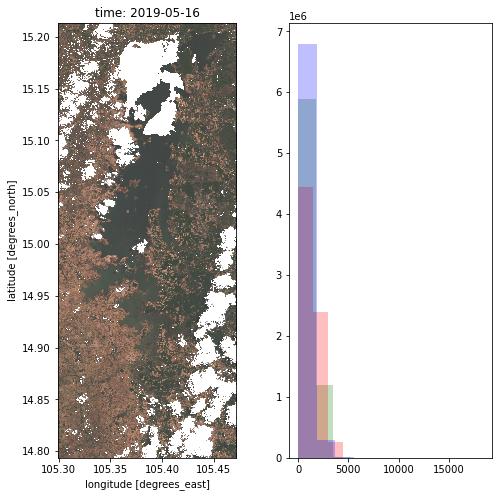

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import xrspatial.multispectral as ms

# load data
# datas_slice = {}
# for b in ["B04", "B03", "B02"]: # get the R G B bands
#     datas_slice[b] = datas[b].isel(time=23)

data_slice = data.isel(time=time_slice_to_get)
data_slice

time = pd.to_datetime(data.time[time_slice_to_get].values)

im = ms.true_color(
    r = data_slice.sel(band="red"),
    g = data_slice.sel(band="green"),
    b = data_slice.sel(band="blue")
)

fig, (ax, ax1) = plt.subplots(figsize=(8, 8), ncols=2)

im.plot.imshow(ax=ax);
ax.set_aspect('equal')
ax.set_title(f"time: {time.strftime('%Y-%m-%d')}")

ax1.hist(data_slice.sel(band="green").values.flatten(), color='green', alpha=0.25)
ax1.hist(data_slice.sel(band="red").values.flatten(), color='red', alpha=0.25)
ax1.hist(data_slice.sel(band="blue").values.flatten(), color='blue', alpha=0.25)

# Let's see how can we use the data to train a clustering model (Cordeiro et al)

In [17]:
print(f"We have: {data.band.values} bands. Additionally, we need NDWI, MNDWI")

We have: ['blue' 'green' 'red' 'nir' 'swir16' 'swir22'] bands. Additionally, we need NDWI, MNDWI


In [18]:
# First scale the data
SCALING_FACTOR = 0.0001
data = data * SCALING_FACTOR

# NDWI
ndwi = ((data.sel(band='green') - data.sel(band='nir'))/(data.sel(band='green') + data.sel(band='nir'))).rename('ndwi').expand_dims(dim='band', axis=1).assign_coords(band=('band', ['ndwi']))
ndwi = ndwi.assign_coords(
    # title='NDWI (Green, NIR)',
    # common_name='ndwi',
    # center_wavelength='NA',
    # full_width_half_max='NA'
)

# MNDWI
mndwi = ((data.sel(band='green') - data.sel(band='swir16'))/(data.sel(band='green') + data.sel(band='swir16'))).rename('mndwi').expand_dims(dim='band', axis=1).assign_coords(band=('band', ['mndwi']))
mndwi = mndwi.assign_coords(
    # title='MNDWI (Green, SWIR1)',
    # common_name='mndwi',
    # center_wavelength='NA',
    # gsd = None,
    # full_width_half_max='NA'
)

In [19]:
data

,Array,Chunk
Bytes,13.81 GiB,7.46 MiB
Shape,"(36, 6, 4644, 1848)","(1, 1, 1028, 951)"
Count,131508 Tasks,2592 Chunks
Type,float64,numpy.ndarray


In [20]:
ndwi

,Array,Chunk
Bytes,2.30 GiB,7.46 MiB
Shape,"(36, 1, 4644, 1848)","(1, 1, 1028, 951)"
Count,134532 Tasks,432 Chunks
Type,float64,numpy.ndarray


In [21]:
mndwi

,Array,Chunk
Bytes,2.30 GiB,7.46 MiB
Shape,"(36, 1, 4644, 1848)","(1, 1, 1028, 951)"
Count,134532 Tasks,432 Chunks
Type,float64,numpy.ndarray


add all the newly estimated indices to the dataset

In [22]:
data = xr.concat([data, ndwi, mndwi], dim='band')
data

,Array,Chunk
Bytes,18.42 GiB,7.46 MiB
Shape,"(36, 8, 4644, 1848)","(1, 1, 1028, 951)"
Count,140580 Tasks,3456 Chunks
Type,float64,numpy.ndarray


Summary of Cordeiro et al methodology:
- A sub-sample of pixels is taken.
- The best K is determined
- An Agglomerative model is trained using the sub-sample of pixels
- Predictions are made for the sub-sample of pixels
- Using the Pixel data and the predictions from the Agglomerative clustering algorithm, a Naive-Bayes Classifier is trained
- Using the Naive-Bayes classifier, the labels of the entire scene is predicted

In [23]:
from sklearn import cluster
from sklearn.metrics import calinski_harabasz_score

In [24]:
test_time_slice = time_slice_to_get
bands = ['ndwi', 'swir16', 'swir22']

# data has to be present in 
data_selection = data.isel(time=test_time_slice).sel(band=bands).values
pre_formatting_shape = data_selection.shape[1:]
formatted_data = data_selection.reshape(len(bands), -1).T

# minmax scaling
from sklearn.preprocessing import MinMaxScaler

results = np.full(formatted_data.shape[0], np.nan)
nonan_idx = np.argwhere(~np.isnan(formatted_data).any(axis=1))

scaler = MinMaxScaler()
formatted_data = scaler.fit_transform(formatted_data)


formatted_data_nonans = formatted_data[~np.isnan(formatted_data).any(axis=1)]
# # formatted_data_nonans = SimpleImputer(missing_values=np.nan, strategy='nearest')
formatted_data_nonans

array([[0.3076553 , 0.2921406 , 0.20718397],
       [0.31179618, 0.27093271, 0.19527684],
       [0.3162001 , 0.27093271, 0.19527684],
       ...,
       [0.17632108, 0.09305056, 0.05913872],
       [0.16266352, 0.09305056, 0.05913872],
       [0.16459779, 0.1036912 , 0.06410002]])

In [25]:
n_samples, n_features = formatted_data_nonans.shape
f"We have {n_samples} samples of {n_features} features"

'We have 7101378 samples of 3 features'

In [26]:
N = 10_000

random_idx = np.random.randint(n_samples, size=N)

input_data_subset = formatted_data_nonans[random_idx, :]
input_data_subset

array([[0.13068087, 0.10090262, 0.03955811],
       [0.71125473, 0.01166801, 0.00932725],
       [0.22207331, 0.21428047, 0.1152345 ],
       ...,
       [0.32908073, 0.36031408, 0.29463518],
       [0.18797372, 0.18389961, 0.09373553],
       [0.3187051 , 0.33617084, 0.2531587 ]])

In [27]:
# Find best k
MIN_K = 2
MAX_K = 7
linkage = 'average'  #https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

def find_best_k(data):
    """
    data: change format according to what sklearn's requirements
    """
    computed_metrics = []
    
    for k in range(MIN_K, MAX_K + 1):
        cluster_model = cluster.AgglomerativeClustering(n_clusters=k, linkage=linkage)

        labels = cluster_model.fit_predict(data)
        
        computed_metrics.append(calinski_harabasz_score(data, labels))
        print('k={} :Calinski_harabaz index={}'.format(k, computed_metrics[k - MIN_K]))
    
    best_k = computed_metrics.index(max(computed_metrics)) + MIN_K
    
    return best_k

best_k = find_best_k(input_data_subset)

print(f"Best K: {best_k}")

k=2 :Calinski_harabaz index=24233.561271126
k=3 :Calinski_harabaz index=12129.487038682711
k=4 :Calinski_harabaz index=18077.81095912519
k=5 :Calinski_harabaz index=13773.210628306644
k=6 :Calinski_harabaz index=18761.774355649628
k=7 :Calinski_harabaz index=17157.16102503736
Best K: 2


In [28]:
# Create the model with the determined best K
cluster_model = cluster.AgglomerativeClustering(n_clusters=best_k, linkage=linkage)

In [29]:
cluster_model.fit(input_data_subset)
subset_labels = cluster_model.labels_.astype('int8')
subset_labels

array([1, 0, 1, ..., 1, 1, 1], dtype=int8)

In [30]:
from sklearn.impute import SimpleImputer

In [31]:
from sklearn.naive_bayes import GaussianNB

gaussian_model = GaussianNB()
gaussian_model.fit(input_data_subset, subset_labels)

# fill na for now, replace them with nans later
# imputer = SimpleImputer(strategy="constant", fill_value=-1)
# formatted_data_for_prediction = imputer.fit_transform(formatted_data)

# labels = gaussian_model.predict(formatted_data_for_prediction).astype(float)
labels = gaussian_model.predict(formatted_data_nonans)

In [32]:
np.put(results, nonan_idx, labels)

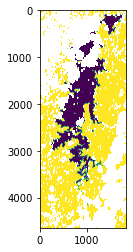

In [33]:
f, ax = plt.subplots()


ax.imshow(results.reshape(pre_formatting_shape))